In [12]:
#import libs
import torch
import os
from ModelZoo import TransformerWithAttentionOutputted
from MyDataset import CustomTimeSeriesDataset
from torch.utils.data import DataLoader

#load our transformer model weights
#Define model to be trained
name = "TransformerWithAttentionOutputted"
model = TransformerWithAttentionOutputted()
nettype = 'Transformer'
model.load_state_dict(torch.load(os.path.join('Model_Parameters', f'{name}_best_parameters.pth')))
device = "cuda" if torch.cuda.is_available() else "cpu"
dataset_test = CustomTimeSeriesDataset('ptbdb_test.csv', NetType=nettype)
#make batch size the size of the test dataset
test_loader = DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=False)

#Evaluate model
model.to(device)
model.eval()  # Set best model to evaluation mode
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass and prepare for plot
        outputs, attention_weights = model(inputs)


/home/fabio/anaconda3/envs/ML4H2/lib/python3.11/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [91]:
np.random.seed(0)

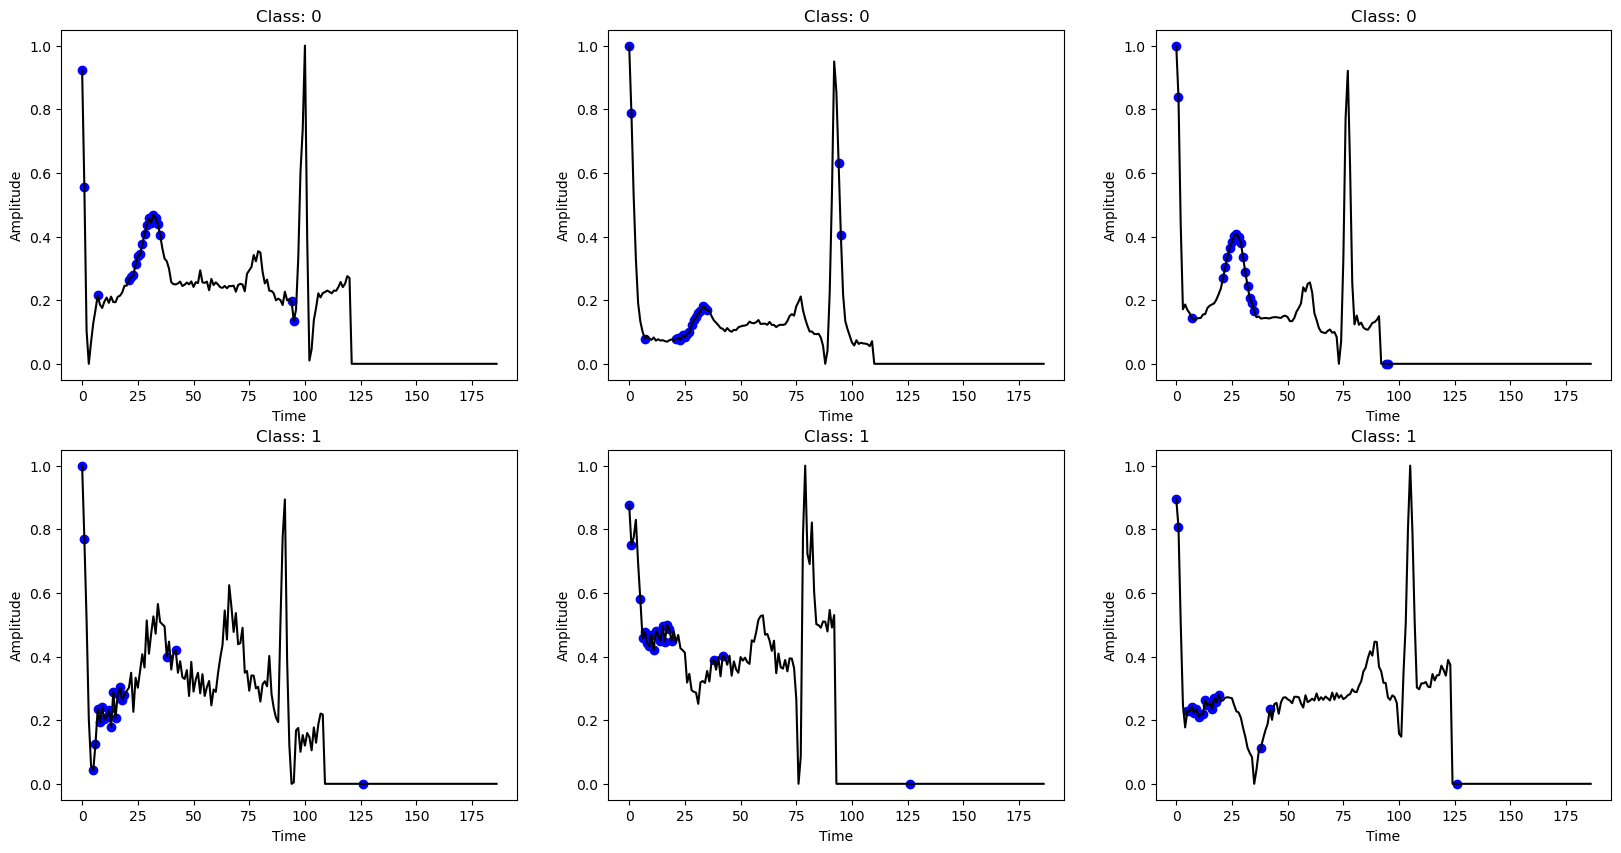

In [98]:
import numpy as np
import matplotlib.pyplot as plt

#2910x187x187
initial_weights_np =attention_weights["layer_1"].cpu().numpy()

#2910x187
average_attention_np = np.mean(initial_weights_np, axis=1)
average_attention_np = average_attention_np / np.max(average_attention_np, axis=1)[:, np.newaxis]

#2910x187
inputs_np = inputs.squeeze(1).cpu().numpy()

#2910x187
labels_np = labels.cpu().numpy()

#select 8 random samples, 4 from each class

normal_indices = np.where(labels_np == 0)[0]
abnormal_indices = np.where(labels_np == 1)[0]
normal_indices = np.random.choice(normal_indices, 4, replace=False)
abnormal_indices = np.random.choice(abnormal_indices, 4, replace=False)

#plot a few time series from both classes, use the average attention to color the points
ii = 2
jj = 3
fig, axs = plt.subplots(ii,jj, figsize=(20, 10))

#find top 20 points with higher attention in each time series
for series in average_attention_np[normal_indices]:
    top_indices_normal = np.argsort(series)[-20:]

for series in average_attention_np[abnormal_indices]:
    top_indices_abnormal = np.argsort(series)[-20:]

for i in range(ii):
    for j in range(jj):
        if i == 0:
            axs[i, j].plot(inputs_np[normal_indices[j]], color='black')
            axs[i, j].scatter(top_indices_normal, inputs_np[normal_indices[j]][top_indices_normal], color='blue')
            axs[i, j].set_title(f"Class: {0}")
            axs[i, j].set_xlabel("Time")
            axs[i, j].set_ylabel("Amplitude")

        else:
            axs[i, j].plot(inputs_np[abnormal_indices[j]], color='black')
            axs[i, j].scatter(top_indices_abnormal, inputs_np[abnormal_indices[j]][top_indices_abnormal], color='blue')
            axs[i, j].set_title(f"Class: {1}")
            axs[i, j].set_xlabel("Time")
            axs[i, j].set_ylabel("Amplitude")


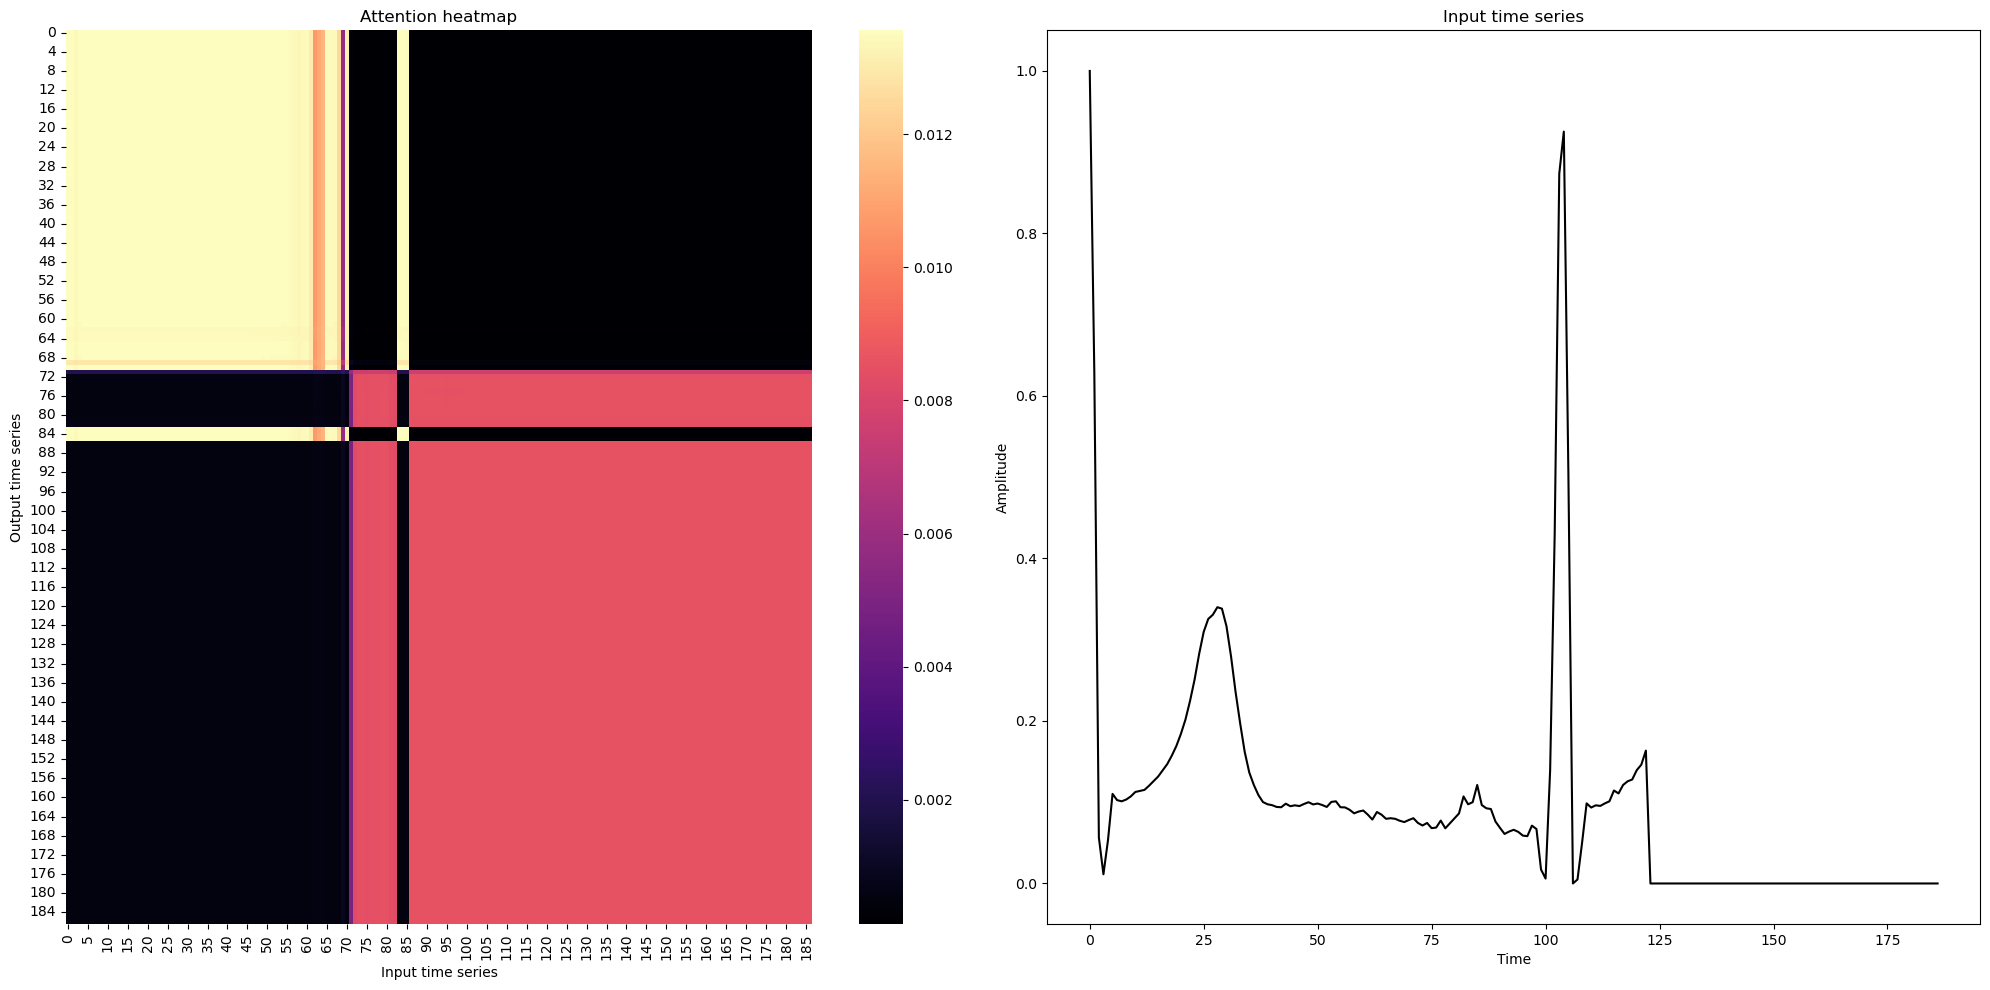

In [87]:
#take all attention from one input
attention = initial_weights_np[abnormal_indices[0]]

# Create a figure
fig = plt.figure(figsize=(20, 10))

#seaborn heatmap
import seaborn as sns
# Add a subplot for the heatmap
ax1 = fig.add_subplot(1, 2, 1)
sns.heatmap(attention, cmap='magma', ax=ax1)
ax1.set_title("Attention heatmap")
ax1.set_xlabel("Input time series")
ax1.set_ylabel("Output time series")

# Add a subplot for the input time series
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(inputs_np[normal_indices[0]], color='black')    
ax2.set_title("Input time series")
ax2.set_xlabel("Time")
ax2.set_ylabel("Amplitude")

# Show the figure
plt.tight_layout()
plt.show()